In [3]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from regions import DS9Parser, read_ds9
from regions import PixCoord, CirclePixelRegion,RectanglePixelRegion, PolygonPixelRegion,EllipsePixelRegion, PolygonSkyRegion

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [109]:
cat_ch1 = Table.read('deepdrill/deepdrill_xmm_20may17_chan1_cat_v2_mag.fits')
cat_ch2 = Table.read('deepdrill/deepdrill_xmm_20may17_chan2_cat_v2_mag.fits')

cat_ch1 = cat_ch1[cat_ch1['mag_auto_ch1']>24]
cat_ch2 = cat_ch2[cat_ch2['mag_auto_ch2']>24]

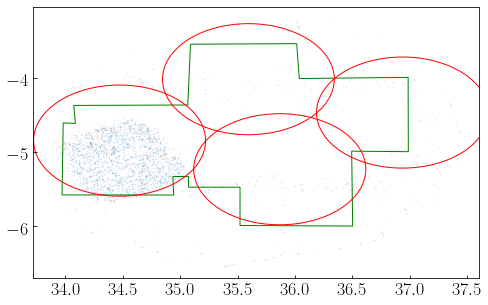

In [110]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5),sharex=True)
plt.scatter(cat_ch1['ra'],cat_ch1['dec'],s=0.1,alpha=0.2)
plt.scatter(cat_ch2['ra'],cat_ch2['dec'],s=0.1,alpha=0.2)

colors=['b','g','r']
xmm_reg_filelist = ['MegaCam_u_xmm.reg','MegaCam_uS_deep_xmm.reg','HSC_xmm.reg']
xmm_radec_lim = [33,38,-7,-3]
for i,filename in enumerate(xmm_reg_filelist):
    file = open('../regions/'+filename)
    lines = file.readlines()
    for line in lines:
        if 'polygon' in line:
            line = 'wcs; fk5\n '+line.rstrip()
            region = DS9Parser(line).shapes.to_regions()[0]
            vertices = region.vertices
            pixel_vertex_x = []
            pixel_vertex_y = []
            for vertex in vertices:
                pixel_vertex_x.append(vertex.ra.value)
                pixel_vertex_y.append(vertex.dec.value)
                pixel_region = PolygonPixelRegion(vertices=PixCoord(x=pixel_vertex_x, y=pixel_vertex_y))
            
            artist = pixel_region.as_artist(edgecolor=colors[i],fill=False)        
            ax.add_artist(artist)
        
        elif 'circle' in line:
            line = 'wcs; fk5\n '+line.rstrip()
            region = DS9Parser(line).shapes.to_regions()[0]
            x = region.center.ra.value
            y = region.center.dec.value
            pixel_center = PixCoord(x=x, y=y)
            pixel_ra_axis = region.radius.value/np.cos(region.center.dec.value/180*np.pi)/3600
            pixel_dec_axis = region.radius.value/3600
            pixel_region = EllipsePixelRegion(pixel_center, pixel_ra_axis*2,pixel_dec_axis*2)
        
            artist = pixel_region.as_artist(edgecolor=colors[i],fill=False)        
            ax.add_artist(artist)
            

#### Convert flux to magnitude

In [139]:
def flux2mag(fluxes):
    # flux in microJanksky
    # mags in AB
    return  2.5*(23-np.log10(fluxes/1e6))-48.6

In [30]:
mag_ch1 = flux2mag(cat_ch1['FluxAuto_3p6'])
mag_ch1[np.isnan(mag_ch1)]=99

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [39]:
# add mag info to the catalogs
cat_ch1 = Table.read('deepdrill/deepdrill_xmm_20may17_chan1_cat_v2.fits')

mag_ch1 = flux2mag(cat_ch1['FluxAuto_3p6'])
mag_ch1[np.isnan(mag_ch1)]=99    
col_magch1 = Column(name='mag_auto_ch1',data=mag_ch1)

mag_ch1_inf = flux2mag(cat_ch1['FluxAuto_3p6']-cat_ch1['FluxErrAuto_3p6'])
mag_ch1_inf[np.isnan(mag_ch1_inf)]=99  
col_magch1_inf = Column(name='mag_auto_ch1_inf',data=mag_ch1_inf)

mag_ch1_sup = flux2mag(cat_ch1['FluxAuto_3p6']+cat_ch1['FluxErrAuto_3p6'])
mag_ch1_sup[np.isnan(mag_ch1_sup)]=99  
col_magch1_sup = Column(name='mag_auto_ch1_sup',data=mag_ch1_sup)

if 'mag_auto_ch1_sup' in cat_ch1.keys():
    cat_ch1.remove_columns(['mag_auto_ch1','mag_auto_ch1_inf','mag_auto_ch1_sup'])
cat_ch1.add_columns([col_magch1,col_magch1_inf,col_magch1_sup])
cat_ch1.write('deepdrill/deepdrill_xmm_20may17_chan1_cat_v2_mag.fits',overwrite=True)

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [40]:
# add mag info to the catalogs
cat_ch2 = Table.read('deepdrill/deepdrill_xmm_20may17_chan2_cat_v2.fits')

mag_ch2 = flux2mag(cat_ch2['FluxAuto_4p5'])
mag_ch2[np.isnan(mag_ch2)]=99    
col_magch2 = Column(name='mag_auto_ch2',data=mag_ch2)

mag_ch2_inf = flux2mag(cat_ch2['FluxAuto_4p5']-cat_ch2['FluxErrAuto_4p5'])
mag_ch2_inf[np.isnan(mag_ch2_inf)]=99  
col_magch2_inf = Column(name='mag_auto_ch2_inf',data=mag_ch2_inf)

mag_ch2_sup = flux2mag(cat_ch2['FluxAuto_4p5']+cat_ch2['FluxErrAuto_4p5'])
mag_ch2_sup[np.isnan(mag_ch2_sup)]=99  
col_magch2_sup = Column(name='mag_auto_ch2_sup',data=mag_ch2_sup)

if 'mag_auto_ch1_sup' in cat_ch2.keys():
    cat_ch2.remove_columns(['mag_auto_ch2','mag_auto_ch2_inf','mag_auto_ch2_sup'])
cat_ch2.add_columns([col_magch2,col_magch2_inf,col_magch2_sup])
cat_ch2.write('deepdrill/deepdrill_xmm_20may17_chan2_cat_v2_mag.fits',overwrite=True)

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


#### gzCH1 plot

In [50]:
cat_added = Table.read('/Volumes/LejaySSD/XMM-LSS_deep_CLAUDS_v9_CH1_CH2.fits')
cat_added = cat_added[np.logical_and(cat_added['MASK']==0, cat_added['inside_uS']==True) ]

cat_added_forced = Table.read('/Volumes/LejaySSD/XMM-LSS_deep_CLAUDS_v9_CH1_CH2_Forced.fits')
cat_added_forced = cat_added_forced[np.logical_and(cat_added_forced['MASK']==0, cat_added_forced['inside_uS']==True) ]

cat_added_shiraz = Table.read('/Volumes/LejaySSD/COSMOS_deep_CLAUDS_v9_CH1_CH2_corr.fits')
cat_added_shiraz = cat_added_shiraz[np.logical_and(cat_added_shiraz['MASK']==0, cat_added_shiraz['inside_u']==True) ]

In [51]:
print(len(cat_added))
print(len(cat_added_forced))
print(len(cat_added_shiraz))

3557322
3557322
2757450


In [47]:
area_cosmos = 4.406492756179495
area_xmm = 7.2547367302496015

In [186]:
# sample size
# cat_size = 500000
# select_ids = np.random.choice(np.arange(len(cat_added)), size=cat_size, replace=False)
# cat_added_select = cat_added[select_ids]
cat_added_select = cat_added

# magnitude cut
mag_cut = 20
cat_added_select = cat_added_select[cat_added_select['i']<mag_cut]
cat_added_select = cat_added_select[cat_added_select['i']>-90]

select_ids = np.random.choice(np.arange(len(cat_added_shiraz)), size=cat_size, replace=False)
cat_added_shiraz_select = cat_added_shiraz[select_ids]
cat_added_shiraz_select = cat_added_shiraz_select[cat_added_shiraz_select['i']<mag_cut]
cat_added_shiraz_select = cat_added_shiraz_select[cat_added_shiraz_select['i']>-90]

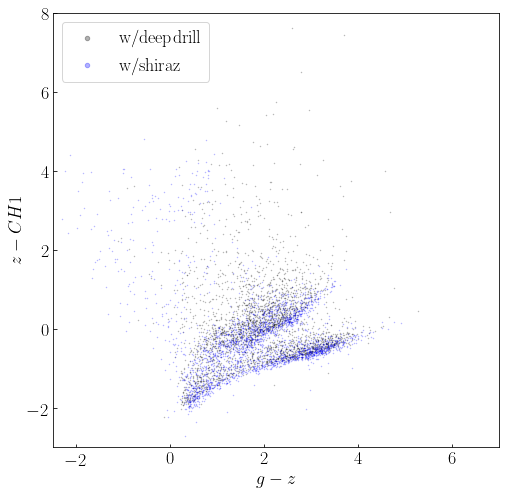

In [187]:
fig, axs = plt.subplots(1, 1, figsize = (8, 8),sharex=True)

plt.scatter(cat_added_select['g']-cat_added_select['z'],cat_added_select['z']-cat_added_select['MAG_AUTO_CH1'],color='k',s=0.2,alpha=0.3,label='w/deepdrill')
plt.scatter(cat_added_shiraz_select['g']-cat_added_shiraz_select['z'],cat_added_shiraz_select['z']-cat_added_shiraz_select['MAG_AUTO_CH1'],color='b',s=0.2,alpha=0.3,label='w/shiraz')

plt.xlim(-2.5,7)
plt.ylim(-3,8)
plt.xlabel('$g-z$',fontsize=18)
plt.ylabel('$z-CH1$',fontsize=18)
plt.legend(fontsize=18,markerscale=10)
plt.show()

In [73]:
mag_cut = 26
gz = 3
gz_width = 0.5

# cat_added_select2 = cat_added[cat_added['i']<mag_cut]
cat_added_select2 = cat_added[cat_added['MAG_AUTO_CH1']>-90]
cat_added_select2 = cat_added_select2[cat_added_select2['i']>-90]
cat_added_select2 = cat_added_select2[abs(cat_added_select2['g']-cat_added_select2['z']-gz)<gz_width]
print(len(cat_added_select2))

# cat_added_forced_select2 = cat_added_forced[cat_added_forced['i']<mag_cut]
cat_added_forced_select2 = cat_added_forced[cat_added_forced['Mag_CH1']>-90]
cat_added_forced_select2 = cat_added_forced_select2[cat_added_forced_select2['i']>-90]
cat_added_forced_select2 = cat_added_forced_select2[abs(cat_added_forced_select2['g']-cat_added_forced_select2['z']-gz)<gz_width]
print(len(cat_added_forced_select2))

# cat_added_shiraz_select2 = cat_added_shiraz[cat_added_shiraz['i']<mag_cut]
cat_added_shiraz_select2 = cat_added_shiraz[cat_added_shiraz['MAG_AUTO_CH1']>-90]
cat_added_shiraz_select2 = cat_added_shiraz_select2[cat_added_shiraz_select2['i']>-90]
cat_added_shiraz_select2 = cat_added_shiraz_select2[abs(cat_added_shiraz_select2['g']-cat_added_shiraz_select2['z']-gz)<gz_width]
print(len(cat_added_shiraz_select2))

62738
42582
53931


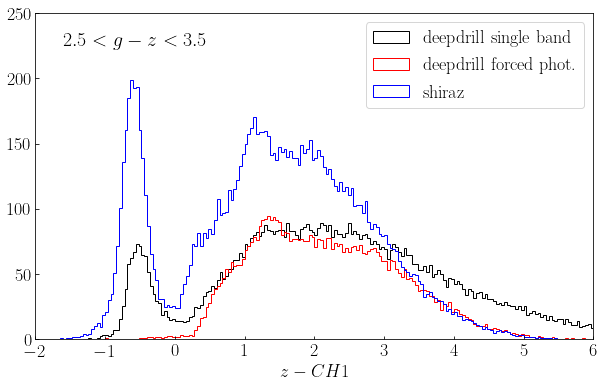

In [74]:
fig, axs = plt.subplots(1, 1, figsize = (10, 6),sharex=True)

plt.hist(cat_added_select2['z']-cat_added_select2['MAG_AUTO_CH1'],
         range=(-2,6),bins=200,weights=1/area_xmm*np.ones(len(cat_added_select2)),color='k',histtype='step',label='deepdrill single band')
plt.hist(cat_added_forced_select2['z']-cat_added_forced_select2['Mag_CH1'],
         range=(-2,6),bins=200,weights=1/area_xmm*np.ones(len(cat_added_forced_select2)),color='r',histtype='step',label='deepdrill forced phot.')
plt.hist(cat_added_shiraz_select2['z']-cat_added_shiraz_select2['MAG_AUTO_CH1'],color='b',
         weights=1/area_cosmos*np.ones(len(cat_added_shiraz_select2)),range=(-2,6),bins=200,histtype='step',label='shiraz')

plt.annotate('$'+str(gz-gz_width)+'<g-z<'+str(gz+gz_width)+'$',xy=([0.05,0.9]),xycoords='axes fraction',fontsize=20,color='k')
plt.xlim(-2,6)
plt.ylim(0,250)
plt.xlabel('$z-CH1$',fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [58]:
cat_deepdrill = Table.read('deepdrill/deepdrill_xmm_20may17_chan1_cat_v2_mag.fits')
cat_deepdrill_forced = Table.read('/Volumes/LejaySSD/deepdrill/deepdrillphot_xmm.fits')
cat_shiraz = Table.read('/Volumes/LejaySSD/SHIRAZ_catalogs/COSMOS_scosmos_ext_CH1_trim.fits')

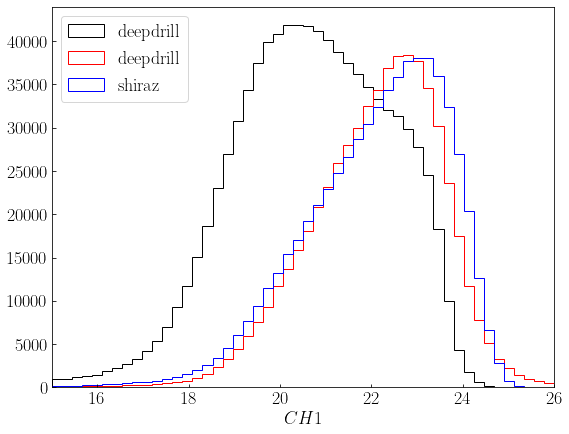

In [69]:
fig, axs = plt.subplots(1, 1, figsize = (9, 7),sharex=True)

plt.hist(cat_deepdrill['mag_auto_ch1'],bins=50,color='k',range=(15,26),weights=np.ones(len(cat_deepdrill)),histtype='step',label='deepdrill')
plt.hist(cat_deepdrill_forced['Mag_CH1'],bins=50,color='r',range=(15,26),weights=0.85*np.ones(len(cat_deepdrill_forced)),histtype='step',label='deepdrill')
plt.hist(cat_shiraz['MAG_AUTO_CH1'],color='b',bins=50,range=(15,26),histtype='step',label='shiraz')
plt.xlim(15,26)
plt.xlabel('$CH1$',fontsize=18)
plt.legend(fontsize=18,loc='upper left')
plt.show()

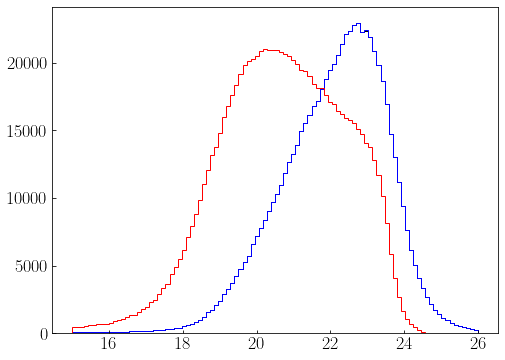

In [158]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6),sharex=True)

mag_ch1 = flux2mag(cat_forced['F_CH1'])

plt.hist(mag_ch1,bins=100,color='k',range=(15,26),histtype='step')
plt.hist(cat_forced['Mag_CH1'],bins=100,range=(15,26),color='b',histtype='step')
plt.hist(cat_deepdrill['mag_auto_ch1'],bins=100,range=(15,26),color='r',histtype='step')
plt.show()

In [170]:
for mag in np.arange(14.25,22.75,0.5):
    cat_forced_selected = cat_forced[np.logical_and(cat_forced['Mag_CH1']>mag,cat_forced['Mag_CH1']<mag+0.5)]
    print(mag, round(np.log10(len(cat_forced_selected)/1.5/3.3),4))

14.25 1.4453
14.75 1.8133
15.25 1.8304
15.75 1.9368
16.25 2.0696
16.75 2.1752
17.25 2.4207
17.75 2.6547
18.25 3.0149
18.75 3.3477
19.25 3.6102
19.75 3.8134
20.25 3.9633
20.75 4.0894
21.25 4.1803
21.75 4.251
22.25 4.3092


In [184]:
for mag in np.arange(14.25,22.75,0.5):
    cat_deepdrill_selected = cat_deepdrill[np.logical_and(cat_deepdrill['mag_auto_ch1']>mag,cat_deepdrill['mag_auto_ch1']<mag+0.5)]
    print(mag, round(np.log10(len(cat_deepdrill_selected)/0.4),4))

14.25 2.07
14.75 2.2788
15.25 2.4472
15.75 2.574
16.25 2.6744
16.75 2.9857
17.25 3.2443
17.75 3.5192
18.25 3.7296
18.75 3.8802
19.25 3.9916
19.75 4.0265
20.25 4.0393
20.75 4.0068
21.25 3.9929
21.75 3.9312
22.25 3.9016
